In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import math

In [4]:
#载入数据集
mnist = input_data.read_data_sets("MNIST_data",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [32]:
class Model(object):
    def _batch_normal(self,x,training,epsilon=1e-3, decay=0.99):
        size = x.shape.as_list()[1]
        scale = tf.Variable(tf.ones((size,))*0.1,trainable=True)
        offset = tf.Variable(tf.zeros((size,)),trainable=True)

        pop_mean =  tf.Variable(tf.zeros((size,)),trainable=False)
        pop_var =  tf.Variable(tf.ones((size,)),trainable=False)
        batch_mean, batch_var = tf.nn.moments(x, [0])
        train_mean_op = tf.assign(pop_mean, pop_mean*decay+batch_mean*(1-decay))
        train_var_op = tf.assign(pop_var, pop_var*decay + batch_var*(1-decay))

        def batch_statistics():
            with tf.control_dependencies([train_mean_op, train_var_op]):
                return tf.nn.batch_normalization(x, batch_mean, batch_var, offset, scale, epsilon)

        def population_statistics():
            return tf.nn.batch_normalization(x, pop_mean, pop_var, offset, scale, epsilon)

        return tf.cond(training, batch_statistics, population_statistics)
    
    def __init__(self,l1_batch_normal,l2_batch_normal,x,y,drop_rate,isTrain,name):
        self.name = name
        self.learning_rate = tf.Variable(0.001,trainable=False)
        epsilon = 1e-8

        #784-400-150-10神经网络(BN)
        wL1 = tf.Variable(tf.truncated_normal([784,400]))
        bL1 = tf.Variable(tf.zeros([400]))
        mL1 = tf.matmul(x,wL1) + bL1
        if l1_batch_normal:
            batch_normal1 = self._batch_normal(mL1,isTrain,epsilon)
            rL1 = tf.nn.sigmoid(batch_normal1) 
        else:
            rL1 = tf.nn.sigmoid(mL1) 
        rL1 = tf.nn.dropout(rL1,rate=drop_rate)

        wL2 = tf.Variable(tf.truncated_normal([400,150]))
        bL2 = tf.Variable(tf.zeros([150]))
        mL2 = tf.matmul(rL1,wL2) + bL2
        if l2_batch_normal:
            batch_normal2 = self._batch_normal(mL2,isTrain,epsilon)
            rL2 = tf.nn.sigmoid(batch_normal2) 
        else:
            rL2 = tf.nn.sigmoid(mL2) 
        rL2 = tf.nn.dropout(rL2,rate=drop_rate)

        wL3 = tf.Variable(tf.truncated_normal([150,10]))
        bL3 = tf.Variable(tf.zeros([10]))
        logits = tf.matmul(rL2,wL3) + bL3
        self.prediction = tf.nn.softmax(logits)

        #代价函数
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(y,logits))

        #梯度下降法
        self.train = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        #结果存在一个布尔型列表中。m*1
        predictionIndex = tf.argmax(self.prediction,1)
        realIndex = tf.argmax(y,1)
        correct_prediction = tf.equal(predictionIndex,realIndex)

        #update learning_rate
        self.update_rate = tf.assign(self.learning_rate,self.learning_rate*0.95)

        #求准确率
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [33]:
tf.reset_default_graph()

#batch_size
batch_size = 128
#计算批次
n_batch = math.ceil(mnist.train.num_examples / batch_size)

x = tf.placeholder(tf.float32,[None,784]) #28*28=784
y = tf.placeholder(tf.float32,[None,10]) #28*28=784
drop_rate = tf.placeholder_with_default(0.1,None)
isTrain = tf.placeholder_with_default(False,None)

NONE_BN_MODEL = "None BN"
L1_BN_MODEL = "BN L1"
L2_BN_MODEL = "BN L2"
ALL_BN_MODEL = "BN All"

model_0_0 = Model(False,False,x,y,drop_rate,isTrain,NONE_BN_MODEL)
model_1_0 = Model(True,False,x,y,drop_rate,isTrain,L1_BN_MODEL)
model_0_1 = Model(False,True,x,y,drop_rate,isTrain,L2_BN_MODEL)
model_1_1 = Model(True,True,x,y,drop_rate,isTrain,ALL_BN_MODEL)

models = []
models.append(model_0_0)
models.append(model_1_0)
models.append(model_0_1)
models.append(model_1_1)

In [34]:
staticist = {}
#handle
staticist["steps"] = []
for model in models:
    staticist[model.name] = {}
    staticist[model.name]["test_acc"] = []
    staticist[model.name]["train_acc"] = []
    staticist[model.name]["train_loss"] = []
    staticist[model.name]["test_loss"] = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for loop in range(100):
        for batch in range(n_batch):
            batch_xs,batch_ys = mnist.train.next_batch(batch_size)
            for model in models:
                sess.run(model.train,feed_dict={x:batch_xs,y:batch_ys,drop_rate:0.1,isTrain:True})
        else:
            staticist["steps"].append(loop)
            for model in models:
                learningRateValue = sess.run(model.update_rate)
                test_acc,test_loss = sess.run([model.accuracy,model.loss],feed_dict = {x:mnist.test.images,y:mnist.test.labels,drop_rate:0,isTrain:False})
                train_acc,train_loss = sess.run([model.accuracy,model.loss],feed_dict = {x:mnist.train.images,y:mnist.train.labels,drop_rate:0,isTrain:False})
                staticist[model.name]["test_acc"].append(test_acc)
                staticist[model.name]["train_acc"].append(train_acc)
                staticist[model.name]["train_loss"].append(train_loss)
                staticist[model.name]["test_loss"].append(train_loss)
                if loop % 10 == 0:
                    print("loop = {}, model = {},   test_acc = {},   train_acc = {}, learning rate = {}".format(loop,model.name,test_acc,train_acc,learningRateValue))

loop = 0, model = None BN,   test_acc = 0.8440999984741211,   train_acc = 0.8330000042915344, learning rate = 0.0009500000160187483
loop = 0, model = BN L1,   test_acc = 0.8416000008583069,   train_acc = 0.83478182554245, learning rate = 0.0009500000160187483
loop = 0, model = BN L2,   test_acc = 0.9045000076293945,   train_acc = 0.899399995803833, learning rate = 0.0009500000160187483
loop = 0, model = BN All,   test_acc = 0.8795999884605408,   train_acc = 0.8696545362472534, learning rate = 0.0009500000160187483
loop = 10, model = None BN,   test_acc = 0.9435999989509583,   train_acc = 0.9588545560836792, learning rate = 0.0005688000237569213
loop = 10, model = BN L1,   test_acc = 0.9416000247001648,   train_acc = 0.9420363903045654, learning rate = 0.0005688000237569213
loop = 10, model = BN L2,   test_acc = 0.965399980545044,   train_acc = 0.9787091016769409, learning rate = 0.0005688000237569213
loop = 10, model = BN All,   test_acc = 0.9283999800682068,   train_acc = 0.9303454756

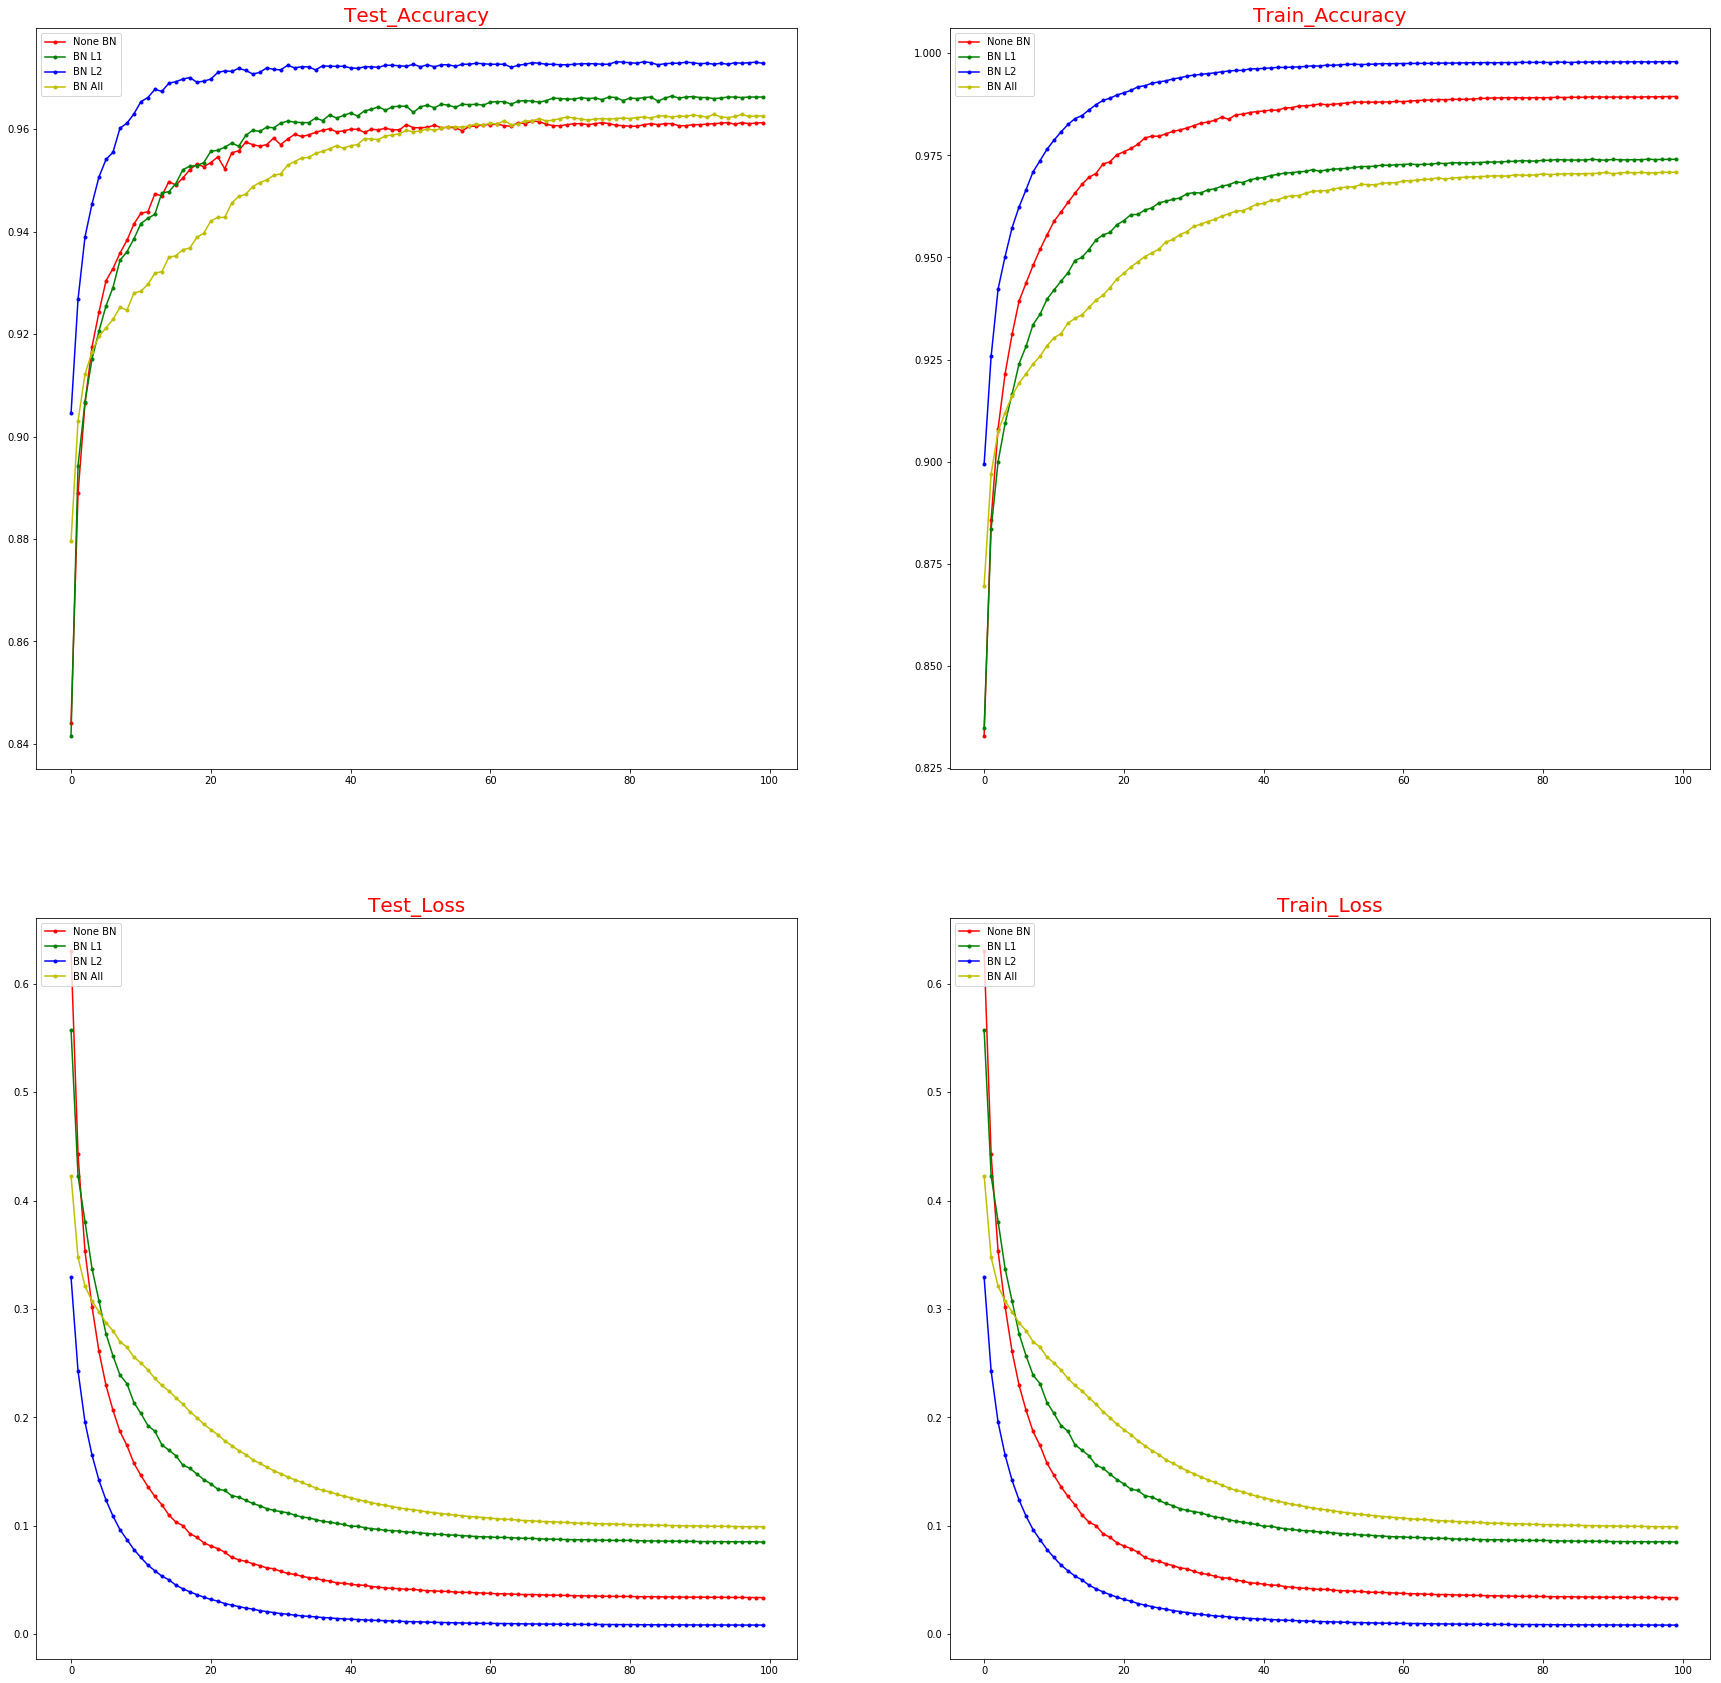

In [37]:
def draw_staticist_data(staticist,ax,key,title,color_map):
    ax.set_title(title,color='r',fontsize=20)
    color = 'k'
    for model in models:
        if model.name in color_map:
            color = color_map[model.name]
        if model.name in staticist:
            model_data = staticist[model.name]
            if key in model_data:
                ax.plot(staticist["steps"],model_data[key],".-",color=color,label=model.name)
    ax.legend(loc=2)

#color_map
color_map = {}
color_map[NONE_BN_MODEL] = 'r'
color_map[L1_BN_MODEL] = 'g'
color_map[L2_BN_MODEL] = 'b'
color_map[ALL_BN_MODEL] = 'y'

plt.figure(figsize=(30,30))
ax = plt.subplot(2,2,1)
draw_staticist_data(staticist,ax,"test_acc","Test_Accuracy",color_map)
ax = plt.subplot(2,2,2)
draw_staticist_data(staticist,ax,"train_acc","Train_Accuracy",color_map)
ax = plt.subplot(2,2,3)
draw_staticist_data(staticist,ax,"test_loss","Test_Loss",color_map)
ax = plt.subplot(2,2,4)
draw_staticist_data(staticist,ax,"train_loss","Train_Loss",color_map)
plt.show()